In [85]:
import pandas as pd
import numpy as np
import os
import itertools
from matplotlib import pyplot as plt

cpapth = os.getcwd()

In [51]:
# https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries?select=ds_salaries.csv
salaries = pd.read_csv(r"Data/ds_salaries.csv")
salaries = salaries.drop(columns=["Unnamed: 0", "work_year", "employment_type",
                                  "salary", "salary_currency",])#.sample(n=100, random_state=32)
salaries

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,79833,DE,0,DE,L
1,SE,Machine Learning Scientist,260000,JP,0,JP,S
2,SE,Big Data Engineer,109024,GB,50,GB,M
3,MI,Product Data Analyst,20000,HN,0,HN,S
4,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...
602,SE,Data Engineer,154000,US,100,US,M
603,SE,Data Engineer,126000,US,100,US,M
604,SE,Data Analyst,129000,US,0,US,M
605,SE,Data Analyst,150000,US,100,US,M


In [55]:
# salaries.experience_level.unique()

\begin{equation}
C(n, 2) = \frac{{n \cdot (n - 1)}}{2}
\end{equation}
possible Connections

In [52]:
n_permutes = lambda n : (n * (n-1)) / 2
print(n_permutes(salaries.shape[0]))

183921.0


In [79]:
idx = salaries.index
idx_pairs = list(itertools.combinations(idx, 2))

salary = salaries.salary_in_usd
salary_pairs = list(itertools.combinations(salary, 2))
salary_delta = [abs(pair[0] - pair[1]) for pair in salary_pairs]

residence = salaries.employee_residence
residence_pairs = list(itertools.combinations(residence, 2))
fellow_country = [int(pair[0] == pair[1] )for pair in residence_pairs]

residence = salaries.experience_level
experience_pairs = list(itertools.combinations(residence, 2))
same_experience = [int(pair[0] == pair[1] )for pair in experience_pairs]

title = salaries.experience_level
title_pairs = list(itertools.combinations(residence, 2))
same_title = [int(pair[0] == pair[1] )for pair in title_pairs]

df = pd.DataFrame({'idx': idx_pairs, 
                   'salary_delta': salary_delta,
                   'fellow_country': fellow_country, 
                   'same_title': same_title, 
                   'same_experience': same_experience
                   })

In [ ]:
# I want to create synthetic target variables from the sigmoid function. Let's take two variables. A dummy variable that is 1, if both persons are in the same country and 0 otherwise, called "countrymen". The second variable is "wagedelta", a numeric variable indicating the abs difference of the wages between both persons. The target represents wheter these two persons form a connection or not. We have the formula and our x variables, we only need some coefficients, that are interpretable. Like how should beta for countrymen be, if i want fellow countrymen to form a connection twice as likely as non fellows


\begin{equation}
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_{equalexper}x_{equalexper} + \beta_{wagedelta}x_{wagedelta} + \ldots + \beta_nx_n)}}
\end{equation}

C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


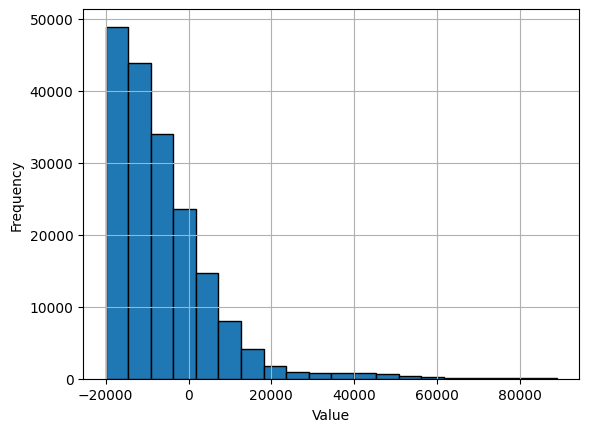

<Axes: >

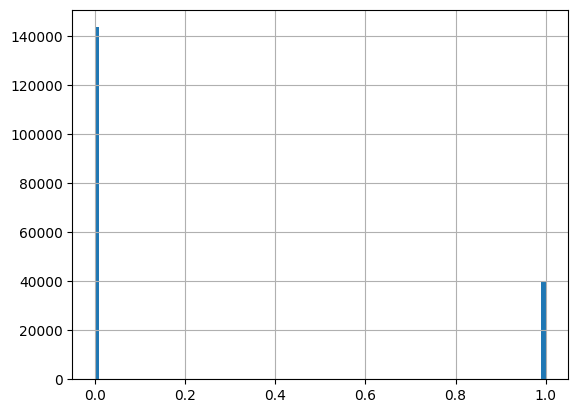

In [90]:
beta_0 = -20000  # Intercept
beta_1 = np.log(1.2)  # Coefficient for countrymen
beta_2 = 0.00000005  # Coefficient for wagedelta

# Calculate log odds
log_odds = beta_0 + beta_1 * df.salary_delta + beta_2 * df.fellow_country
probability = 1 / (1 + np.exp(-log_odds))

hist, bins = np.histogram(log_odds, bins=20)  # Adjust the number of bins as needed

# Plot the histogram
plt.hist(log_odds, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

probability.hist(bins = 100)